Let's gather a few datasets from the ISIC database
# Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from pathlib import Path
import tensorflow as tf

In [ ]:
BCN = pd.read_csv(r'E:\Capstone Skin Cancer Project\Datasets\BCN\MetaData\BCN_Metadata.csv')
BCN.head(5)

In [ ]:
HAM = pd.read_csv(r'E:\Capstone Skin Cancer Project\Datasets\HAM\MetaData\HAM_Metadata.csv')
HAM.head(5)

In [ ]:
BA = pd.read_csv(r'E:\Capstone Skin Cancer Project\Datasets\BuenosAires\MetaData\BA_Metadata.csv', low_memory=False)
BA.head(5)

In [ ]:
BRAFF = pd.read_csv(r'E:\Capstone Skin Cancer Project\Datasets\Braff\MetaData\Braff_Metadata.csv')
BRAFF.head(5)

In [ ]:
MELO = pd.read_csv(r'E:\Capstone Skin Cancer Project\Datasets\Melo\MetaData\Melo_Metadata.csv', low_memory=False)
MELO.head(5)

After all data has been read, we'll make a function to format all of the data

In [ ]:
columns_to_keep = ['isic_id', 'age_approx', 'sex', 'anatom_site_general', 'diagnosis_1', 'diagnosis']
translation_dict = {
		'upper extremity': 'Shoulders & Arms',
		'head/neck':       'Head & Neck',
		'palms/soles':     'Palms & Soles',
		'anterior torso':  'Front Torso',
		'lower extremity': 'Legs',
		'oral/genital':    'Mouth & Groin',
		'posterior torso': 'Back',
		'lateral torso':   'Side Torso (Ribs)', }


def dataFormatting(table):
	if 'diagnosis' not in table.columns and 'diagnosis_2' in table.columns:
		table['diagnosis'] = table['diagnosis_2']

	# Update the 'diagnosis' column if it's blank by using the value from 'diagnosis_1'
	table.loc[table['diagnosis'].isna(), 'diagnosis'] = table['diagnosis_1']

	# Normalize the text in the 'diagnosis' column for consistent filtering
	table['diagnosis'] = table['diagnosis'].str.strip().str.lower()

	# Remove rows where diagnosis_1 (Benign/Malignant) is "Indeterminate"
	table = table[table['diagnosis_1'].str.strip() != "Indeterminate"]

	table = table.dropna(subset=columns_to_keep)  # Drop any columns that don't have the data we need.

	formatted_table = table[columns_to_keep]
	formatted_table = formatted_table.rename(columns={'age_approx':          'Age',
	                                                  'sex':                 'Gender',
	                                                  'anatom_site_general': 'Location',
	                                                  'diagnosis_1':         'Benign/Malignant',
	                                                  'diagnosis':           'Diagnosis'
	                                                  })
	formatted_table['Location'] = formatted_table['Location'].replace(translation_dict)
	formatted_table['Age'] = formatted_table['Age'].astype(int)
	return formatted_table

Lets make one more helper function to find out how many rows are in each table

In [ ]:
def rowCount(tables):
	for name, table in tables.items():
		print(f"{name} has {table.shape[0]} rows")
	total_rows = sum(table.shape[0] for table in tables.values())
	print(f"There are a total of {total_rows} rows in all tables")

In [ ]:
formatted_BCN = dataFormatting(BCN)
formatted_BCN.head(5)

In [ ]:
formatted_HAM = dataFormatting(HAM)
formatted_HAM.head(5)

In [ ]:
formatted_MELO = dataFormatting(MELO)
formatted_MELO.head(5)

In [ ]:
formatted_BA = dataFormatting(BA)
formatted_BA.head(5)

In [ ]:
formatted_BRAFF = dataFormatting(BRAFF)
formatted_BRAFF.head(5)

In [ ]:
tables = {
		"BCN":   formatted_BCN,
		"HAM":   formatted_HAM,
		"MELO":  formatted_MELO,
		"BRAFF": formatted_BRAFF,
		"BA":    formatted_BA
}
rowCount(tables)

In [ ]:
all_data_duplicated = pd.concat([formatted_BCN, formatted_HAM, formatted_MELO, formatted_BRAFF, formatted_BA],
                                ignore_index=True)
all_data = all_data_duplicated.drop_duplicates(subset='isic_id')
all_data.to_csv(r'E:\Capstone Skin Cancer Project\Datasets\all_datasets_combined.csv', index=False)
print(f'There are {len(all_data)} rows in the combined dataset')
duplicate_isic_ids = all_data[all_data['isic_id'].duplicated()]

# Output result
if duplicate_isic_ids.empty:
	print("All isic_id values are unique.")
else:
	print(f"The following isic_id values are duplicated:\n{duplicate_isic_ids}")

In [4]:
all_data = pd.read_csv(r'E:\Capstone Skin Cancer Project\Datasets\all_datasets_combined.csv')

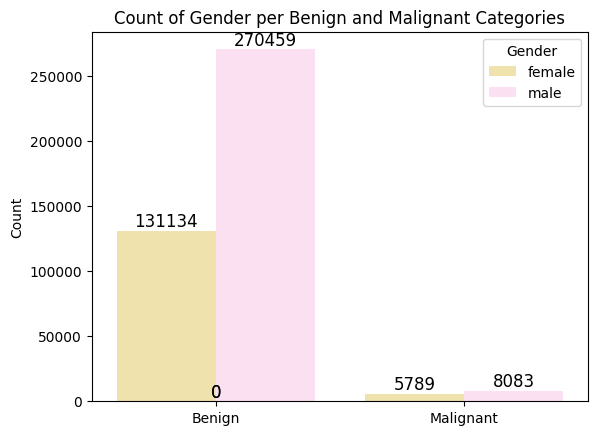

In [5]:
# Group data by 'Gender' and 'Benign/Malignant' and count occurrences
gender_bm_counts = all_data.groupby([
		'Gender',
		'Benign/Malignant']).size().reset_index(name='Count')

# Create the bar plot
ax = sns.barplot(
		data=gender_bm_counts,
		x='Benign/Malignant',
		y='Count',
		hue='Gender',
		palette=['#FBE8A1', '#FFDCF4']
)

# Add bar labels
for bar in ax.patches:
	count = int(bar.get_height())
	ax.text(
			bar.get_x() + bar.get_width() / 2,
			count,
			f"{count}",
			ha='center',
			va='bottom',
			fontsize=12,
			color='black'
	)

plt.legend(title="Gender", loc='upper right')

plt.xlabel("")
plt.ylabel("Count")
plt.title("Count of Gender per Benign and Malignant Categories")

plt.show()

In [ ]:
malignant_data = all_data[all_data['Benign/Malignant'] == 'Malignant']
age_gender_counts = malignant_data.groupby(['Age', 'Gender']).size().reset_index(name='Count')

male_counts = age_gender_counts[age_gender_counts['Gender'] == 'male']
female_counts = age_gender_counts[age_gender_counts['Gender'] == 'female']

plt.plot(male_counts['Age'], male_counts['Count'], label='Male', color='blue')
plt.plot(female_counts['Age'], female_counts['Count'], label='Female', color='pink')

plt.xlabel('Age')
plt.ylabel('Count of Malignant Cases')
plt.title('Count of Malignant Cases by Age and Gender')
plt.legend(title='Gender')
plt.grid(True)
plt.show()

In [ ]:
location_gender_counts = malignant_data.groupby(['Location', 'Gender']).size().reset_index(name='Count')

# Separate the counts by gender
male_location_counts = location_gender_counts[location_gender_counts['Gender'] == 'male']
female_location_counts = location_gender_counts[location_gender_counts['Gender'] == 'female']

# Sort each by count in descending order
male_location_counts = male_location_counts.sort_values(by='Count', ascending=False)
female_location_counts = female_location_counts.sort_values(by='Count', ascending=False)

ax = sns.barplot(
		data=location_gender_counts,
		x='Location',
		y='Count',
		hue='Gender',
		palette=['blue', 'pink']
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.legend(title="Gender", loc='upper right')
plt.xlabel("Location")
plt.ylabel("Count")
plt.title("Count of Malignant Diagnoses by Location and Gender")

plt.tight_layout()
plt.show()

max_length = max(len(male_location_counts), len(female_location_counts))

print(f"{'Male:':<30}{'Female:'}")

for i in range(max_length):
	male_str = f"{male_location_counts.iloc[i]['Location']}: {male_location_counts.iloc[i]['Count']}" if i < len(
			male_location_counts) else ""
	female_str = f"{female_location_counts.iloc[i]['Location']}: {female_location_counts.iloc[i]['Count']}" if i < len(
			female_location_counts) else ""
	print(f"{male_str:<30}{female_str}")

In [ ]:
Benign_data = all_data[all_data['Benign/Malignant'] == 'Benign']
age_gender_counts = Benign_data.groupby(['Age', 'Gender']).size().reset_index(name='Count')

male_counts = age_gender_counts[age_gender_counts['Gender'] == 'male']
female_counts = age_gender_counts[age_gender_counts['Gender'] == 'female']

plt.plot(male_counts['Age'], male_counts['Count'], label='Male', color='blue')
plt.plot(female_counts['Age'], female_counts['Count'], label='Female', color='pink')

plt.xlabel('Age')
plt.ylabel('Count of Benign Cases')
plt.title('Count of Benign Cases by Age and Gender')
plt.legend(title='Gender')
plt.grid(True)
plt.show()

In [ ]:
Benign_location_gender_counts = Benign_data.groupby(['Location', 'Gender']).size().reset_index(name='Count')

# Separate the counts by gender
Benign_male_location_counts = Benign_location_gender_counts[Benign_location_gender_counts['Gender'] == 'male']
Benign_female_location_counts = Benign_location_gender_counts[Benign_location_gender_counts['Gender'] == 'female']

# Sort each by count in descending order
Benign_male_location_counts = Benign_male_location_counts.sort_values(by='Count', ascending=False)
Benign_female_location_counts = Benign_female_location_counts.sort_values(by='Count', ascending=False)

ax = sns.barplot(
		data=Benign_location_gender_counts,
		x='Location',
		y='Count',
		hue='Gender',
		palette=['blue', 'pink']
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.legend(title="Gender", loc='upper right')
plt.xlabel("Location")
plt.ylabel("Count")
plt.title("Count of Benign Diagnoses by Location and Gender")

plt.tight_layout()
plt.show()

max_length = max(len(Benign_male_location_counts), len(Benign_female_location_counts))

print(f"{'Male:':<30}{'Female:'}")

for i in range(max_length):
	male_str = f"{Benign_male_location_counts.iloc[i]['Location']}: {Benign_male_location_counts.iloc[i]['Count']}" if i < len(
			Benign_male_location_counts) else ""
	female_str = f"{Benign_female_location_counts.iloc[i]['Location']}: {Benign_female_location_counts.iloc[i]['Count']}" if i < len(
			Benign_female_location_counts) else ""
	print(f"{male_str:<30}{female_str}")

In [ ]:
from sklearn.preprocessing import OneHotEncoder

metadata_path = r"E:\Capstone Skin Cancer Project\Datasets\all_datasets_combined.csv"

# Load the dataset
all_data = pd.read_csv(metadata_path)

categorical_features = ['Gender', 'Location']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_features = encoder.fit_transform(all_data[categorical_features])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Concatenate encoded metadata with the original DataFrame
all_data_encoded = pd.concat([all_data, encoded_df], axis=1)

# Drop original categorical columns
all_data_encoded.drop(columns=categorical_features, inplace=True)

all_data_encoded.head()

In [3]:
from sklearn.preprocessing import StandardScaler

all_data_encoded = pd.read_csv(r"E:\Capstone Skin Cancer Project\Datasets\all_data_encoded.csv")
# Initialize the scaler
scaler = StandardScaler()

# Normalize numerical columns
all_data_encoded['Age'] = scaler.fit_transform(all_data_encoded['Age'])

# After scaling, inspect the mean and std
print("Mean calculated by StandardScaler:", scaler.mean_)
print("Standard deviation calculated by StandardScaler:", scaler.scale_)


# Display normalized dataset
all_data_encoded.head()

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [ ]:
# Convert labels to numerical format
all_data_encoded['label'] = all_data_encoded['Benign/Malignant'].map({'Benign': 0, 'Malignant': 1})

# Drop the original label column
all_data_encoded.drop(columns=['Benign/Malignant'], inplace=True)

# Display the dataset with labels
all_data_encoded.head()

In [ ]:
all_data_encoded.to_csv(r"E:\Capstone Skin Cancer Project\Datasets\all_data_encoded.csv", index=False)

In [ ]:
image_dirs = [
		r"E:\Capstone Skin Cancer Project\Datasets\BCN\Image",
		r"E:\Capstone Skin Cancer Project\Datasets\Braff\Image",
		r"E:\Capstone Skin Cancer Project\Datasets\BuenosAires\Image",
		r"E:\Capstone Skin Cancer Project\Datasets\HAM\Image",
		r"E:\Capstone Skin Cancer Project\Datasets\Melo\Image"
]
# Store all available images in a set
image_files = set()
for directory in image_dirs:
	for file in os.listdir(directory):
		if file.endswith(".jpg"):
			image_files.add(file)

# Check for missing images
missing_images = all_data_encoded[~all_data_encoded['isic_id'].apply(lambda x: f"{x}.jpg").isin(image_files)]

if not missing_images.empty:
	print("🚨 Missing images found! Listing them below:")
	print(missing_images['isic_id'].tolist())


In [ ]:
# Store full image paths in the metadata
def find_image_path(isic_id):
	filename = f"{isic_id}.jpg"
	for directory in image_dirs:
		full_path = os.path.join(directory, filename)
		if os.path.exists(full_path):
			return full_path
	return None

In [ ]:
# Add image path column
all_data_encoded['image_path'] = all_data_encoded['isic_id'].apply(find_image_path)

In [ ]:
# Drop missing images from the dataset
all_data_encoded = all_data_encoded.dropna(subset=['image_path'])

In [ ]:
# Save updated dataset with image paths
all_data_encoded.to_csv(r"E:\Capstone Skin Cancer Project\Datasets\all_data_with_paths.csv", index=False)
print("✅ Image verification complete! Updated dataset saved.")

In [1]:
all_data_encoded = pd.read_csv(r"E:\Capstone Skin Cancer Project\Datasets\all_data_with_paths.csv")

NameError: name 'pd' is not defined

In [ ]:
# Store resolutions
resolutions = []

for image_path in all_data_encoded['image_path']:
	img = cv2.imread(image_path)
	if img is not None:
		height, width, _ = img.shape
		resolutions.append((width, height))

# Convert to NumPy array
resolutions = np.array(resolutions)

# Find min/max resolution
min_width, min_height = resolutions.min(axis=0)
max_width, max_height = resolutions.max(axis=0)

print(f"📏 Min Resolution: {min_width}x{min_height}")
print(f"📏 Max Resolution: {max_width}x{max_height}")

In [3]:
from sklearn.model_selection import train_test_split

# Split dataset
train_data, test_data = train_test_split(all_data_encoded, test_size=0.2, random_state=42, shuffle=True)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=24, shuffle=True)

print(f"✅ Train samples: {len(train_data)}")
print(f"✅ Test samples: {len(test_data)}")
print(f"✅ Validation samples: {len(val_data)}")


✅ Train samples: 299134
✅ Test samples: 83093
✅ Validation samples: 33238


Lets test some methods to apply a masking method for the segmentation model

In [5]:
def create_mask_otsu(image):
    """
    Create an enhanced binary mask using an improved preprocessing pipeline:
    1. Convert to grayscale.
    2. Enhance contrast using CLAHE.
    3. Denoise with a bilateral filter.
    4. Sharpen using an unsharp mask filter.
    5. Optionally smooth with a Gaussian blur.
    6. Apply Otsu's thresholding.
    7. Clean up with morphological operations.
    """
    # Convert image to grayscale
     # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Enhance local contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Use a bilateral filter to reduce noise while preserving edges
    denoised = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)

    # Sharpen the image using an unsharp masking kernel
    sharpening_kernel = np.array([[-1, -1, -1],
                                 [-1,  9, -1],
                                 [-1, -1, -1]])
    sharpened = cv2.filter2D(denoised, -1, sharpening_kernel)

    # Optional: Apply Gaussian Blur to reduce any high-frequency artifacts
    blurred = cv2.GaussianBlur(sharpened, (5, 5), 0)

    # Apply Otsu's thresholding to create the binary mask
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Use morphological opening to remove small noise artifacts from the mask
    kernel_morph = np.ones((3, 3), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_morph, iterations=1)

    return mask_clean

In [6]:
def preprocess_image_and_mask(image_path):
    """Preprocess an image and create its segmentation mask."""
    # Read and preprocess image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create mask
    try:
        mask = create_mask_otsu(image)
        mask = (mask > 0).astype(np.uint8)  # Convert to binary 0/1
    except Exception as e:
        print(f"Warning: Mask creation failed for {image_path}. Using fallback mask.")
        mask = np.ones(image.shape[:2], dtype=np.uint8)  # Fallback: use entire image

    # Resize both image and mask to 224x224
    image = cv2.resize(image, (224, 224))
    mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)

    # Normalize image to [0,1]
    image = image.astype(np.float32) / 255.0

    return image, mask

In [7]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_list_feature(value):
    """Returns a float_list from a numpy array."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value.flatten()))

def serialize_example(image, mask, metadata, label):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    # Convert image to bytes
    image_bytes = tf.io.encode_jpeg(tf.cast(image * 255, tf.uint8)).numpy()

    # Convert mask to bytes - ensure mask is 3D
    mask_3d = np.expand_dims(mask, axis=-1)  # Add channel dimension
    mask_bytes = tf.io.encode_jpeg(tf.cast(mask_3d * 255, tf.uint8)).numpy()

    feature = {
        'image': _bytes_feature(image_bytes),
        'mask': _bytes_feature(mask_bytes),
        'metadata': tf.train.Feature(float_list=tf.train.FloatList(value=metadata)),
        'label': tf.train.Feature(float_list=tf.train.FloatList(value=[label]))
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [8]:
def write_tfrecord(data, filename):
    """Write dataset to TFRecord including segmentation masks."""
    with tf.io.TFRecordWriter(filename) as writer:
        for idx, row in data.iterrows():
            try:
                # Process image and create mask
                image, mask = preprocess_image_and_mask(row['image_path'])

                # Get metadata and label
                metadata_cols = [col for col in data.columns if col not in ['isic_id', 'image_path', 'label']]
                metadata = row[metadata_cols].values.astype(np.float32)
                label = row['label']

                # Create and write TF Example
                tf_example = serialize_example(image, mask, metadata, label)
                writer.write(tf_example.SerializeToString())
            except Exception as e:
                print(f"Error processing image {row['image_path']}: {str(e)}")
                continue

In [8]:
def parse_tfrecord(example_proto):
    """Parse the input tf.Example proto using the dictionary below."""
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'metadata': tf.io.VarLenFeature(tf.float32),
        'label': tf.io.FixedLenFeature([], tf.float32)
    }

    # Parse the input tf.Example proto using the dictionary above
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Decode the JPEG image and mask
    image = tf.io.decode_jpeg(parsed_features['image'])
    mask = tf.io.decode_jpeg(parsed_features['mask'])

    # Convert to float32 and normalize
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0

    # Remove the extra channel dimension from mask if needed
    mask = mask[:, :, 0]  # Take first channel since mask was encoded as JPEG

    # Ensure shapes are as expected
    image.set_shape([224, 224, 3])
    mask.set_shape([224, 224])

    # Get metadata
    metadata = tf.sparse.to_dense(parsed_features['metadata'])

    # Get label
    label = parsed_features['label']

    return image, mask, metadata, label

In [6]:
def check_data_overlap(train_data, val_data, test_data):
    """
    Check for overlapping data between train, validation, and test sets.

    Args:
        train_data: Training dataset
        val_data: Validation dataset
        test_data: Test dataset

    Returns:
        dict: Dictionary containing overlap information
    """
    # Convert to sets for efficient comparison
    # If your data is a DataFrame, you might need to convert to tuples first
    # Example: train_set = set(map(tuple, train_data.values))
    try:
        train_set = set(map(tuple, train_data.values))
        val_set = set(map(tuple, val_data.values))
        test_set = set(map(tuple, test_data.values))
    except AttributeError:
        # If data is not a DataFrame, try direct conversion
        train_set = set(map(tuple, train_data))
        val_set = set(map(tuple, val_data))
        test_set = set(map(tuple, test_data))

    # Check overlaps
    train_val_overlap = train_set.intersection(val_set)
    train_test_overlap = train_set.intersection(test_set)
    val_test_overlap = val_set.intersection(test_set)

    # Calculate overlap sizes
    results = {
        'train_val_overlap_count': len(train_val_overlap),
        'train_test_overlap_count': len(train_test_overlap),
        'val_test_overlap_count': len(val_test_overlap),
        'train_size': len(train_set),
        'val_size': len(val_set),
        'test_size': len(test_set)
    }

    # Calculate overlap percentages
    results['train_val_overlap_percentage'] = (results['train_val_overlap_count'] / results['train_size']) * 100
    results['train_test_overlap_percentage'] = (results['train_test_overlap_count'] / results['train_size']) * 100
    results['val_test_overlap_percentage'] = (results['val_test_overlap_count'] / results['val_size']) * 100

    return results

# Usage example:
results = check_data_overlap(train_data, val_data, test_data)
for key, value in results.items():
    if 'percentage' in key:
        print(f"{key}: {value:.2f}%")
    else:
        print(f"{key}: {value}")

NameError: name 'train_data' is not defined

In [10]:
write_tfrecord(train_data, r"E:\Capstone Skin Cancer Project\Datasets\train.tfrecord")
write_tfrecord(val_data, r"E:\Capstone Skin Cancer Project\Datasets\validation.tfrecord")
write_tfrecord(test_data, r"E:\Capstone Skin Cancer Project\Datasets\test.tfrecord")

print("✅ TFRecord creation complete!")

✅ TFRecord creation complete!


In [9]:
tfrecord_path = r"E:\Capstone Skin Cancer Project\Datasets\test.tfrecord"
dataset = tf.data.TFRecordDataset(tfrecord_path)
dataset = dataset.map(parse_tfrecord)

# Take first 5 examples
for i, (image, mask, metadata, label) in enumerate(dataset.take(150)):
    print(f"\nExample {i+1}:")
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Metadata: {metadata.numpy()}")
    print(f"Label: {label.numpy()}")


Example 1:
Image shape: (224, 224, 3)
Mask shape: (224, 224)
Metadata: [0.16258992 0.         1.         1.         0.         0.
 0.         0.         0.         0.         0.        ]
Label: 0.0

Example 2:
Image shape: (224, 224, 3)
Mask shape: (224, 224)
Metadata: [0.87114465 0.         1.         0.         0.         1.
 0.         0.         0.         0.         0.        ]
Label: 1.0

Example 3:
Image shape: (224, 224, 3)
Mask shape: (224, 224)
Metadata: [0.16258992 0.         1.         0.         1.         0.
 0.         0.         0.         0.         0.        ]
Label: 0.0

Example 4:
Image shape: (224, 224, 3)
Mask shape: (224, 224)
Metadata: [1.5796994 0.        1.        0.        0.        1.        0.
 0.        0.        0.        0.       ]
Label: 1.0

Example 5:
Image shape: (224, 224, 3)
Mask shape: (224, 224)
Metadata: [-1.2545196  0.         1.         0.         1.         0.
  0.         0.         0.         0.         0.       ]
Label: 1.0

Example 6:
Im